In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [3]:
# 50 by 50 grid
N = 1000

In [4]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N, N))
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = np.random.random((N,N))
lattice_p = np.zeros((N, N))
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

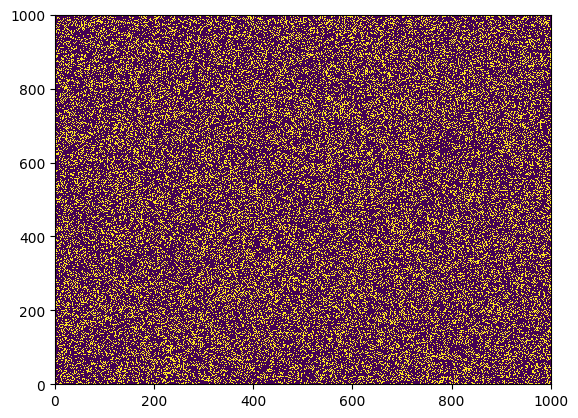

In [5]:
plt.pcolormesh(lattice_n)

In [6]:
kern = generate_binary_structure(2, 1) 
kern[1][1] = False

In [7]:
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [8]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1) 
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)+0.5*lattice
    return arr

def get_energy(lattice):
    return get_energy_arr(lattice).sum()

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

In [9]:
def metropolis(spin_arr, n_iters, BJ):
    energies = []
    avg_spins = []
    spin_arr = spin_arr.copy()
    for t in range(n_iters):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_arr)[i::2,j::2]
        change = (dE>=0)*(np.random.random(dE.shape) < np.exp(-BJ*dE)) + (dE<0)
        spin_arr[i::2,j::2][change] *=-1
        energies.append(get_energy(spin_arr))
        avg_spins.append(spin_arr.sum()/N**2)
    return np.array(avg_spins), np.array(energies)

In [10]:
spins, energies = metropolis(lattice_p, 1000, 0.5)

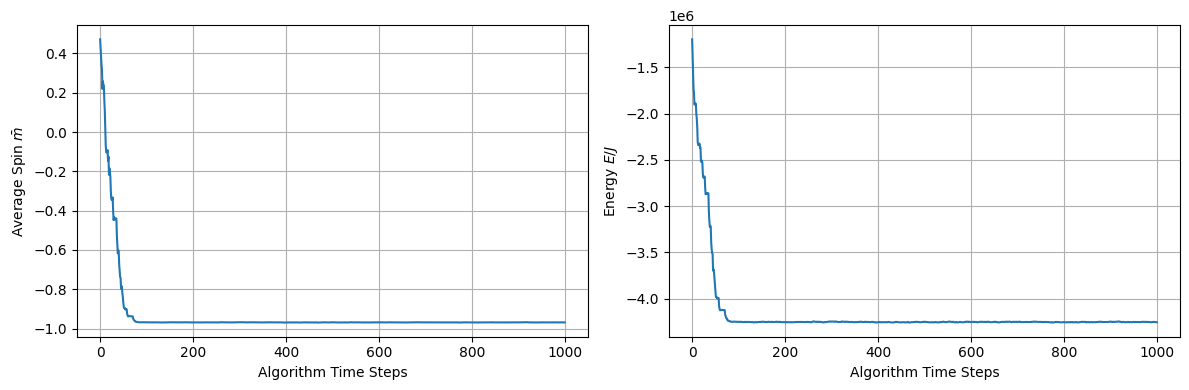

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies)
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

In [12]:
def get_spin_energy(lattice, BJs):
    spins_avg = []
    energies_avg = []
    energies_std = []
    for BJ in BJs:
        spins, energies = metropolis(lattice, 1000, BJ)
        spins_avg.append(np.mean(spins[-400:]))
        energies_avg.append(np.mean(energies[-400:]))
        energies_std.append(np.std(energies[-400:]))
        spins, energies = metropolis(lattice, 1000, BJ)
    return np.array(spins_avg), np.array(energies_avg), np.array(energies_std)
    
BJs = 1/np.linspace(1, 3, 20)
spins_avg_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

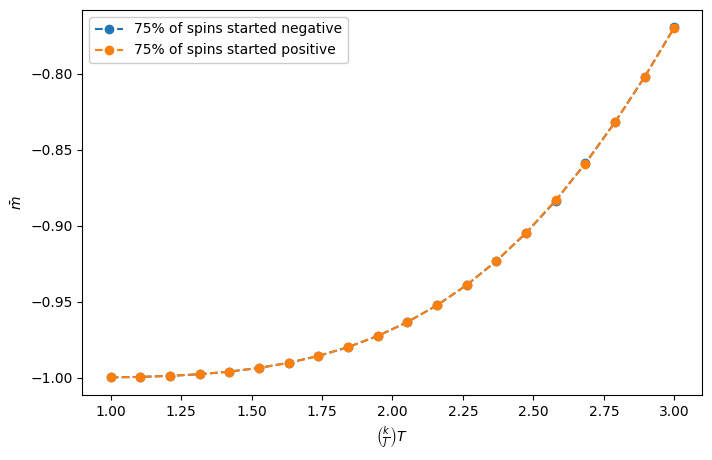

In [13]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, spins_avg_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, spins_avg_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

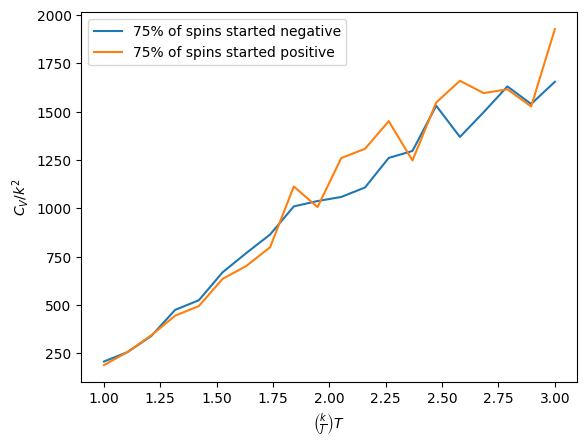

In [14]:
plt.plot(1/BJs, E_stds_n*BJs, label='75% of spins started negative')
plt.plot(1/BJs, E_stds_p*BJs, label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()